# Jax Embedding Tutorial

Now that we can successfully train a neural network that uses embeddings, let's make a version that is exclusively Jax (no Keras weights) and use it as the skeleton of a future tutorial/video.

In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random

import tensorflow as tf
import jax
import jax.numpy as jnp
import functools
import optax

from flax.core import frozen_dict
from flax import struct
from flax import linen as nn
from flax.training import train_state

from matplotlib import pyplot as plt

tf.__version__

'2.7.0'

In [54]:
ratings_df = pd.read_csv("data/movie-lens/rating.csv", usecols=['userId', 'movieId', 'rating', 'y'])
movies_df = pd.read_csv("data/movie-lens/movie.csv", usecols=['movieId', 'title', 'year'])
df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')

In [91]:
df

,userId,movieId,rating,y,title,year
17081086,123425,167,2.0,-1.525502,Free Willy 2: The Adventure Home,1995
11578986,108287,1195,4.0,0.474498,The Godfather: Part II,1974
15951635,109381,3255,5.0,1.474498,Birdy,1984
12481916,64404,2957,5.0,1.474498,Dead Again,1991
15295156,137309,3018,2.5,-1.025502,Awakenings,1990
...,...,...,...,...,...,...
9887681,92733,7031,5.0,1.474498,The Last Samurai,2003
2870845,3306,257,4.5,0.974498,Star Wars: Episode IV - A New Hope,1977
17218241,85148,12123,4.0,0.474498,"Lust, Caution (Se, jie)",2007
4124722,46532,108,3.5,-0.025502,Braveheart,1995


In [55]:
# Shuffle
df = df.sample(frac=1, random_state=1) 
# First 50,000 for test
test_df = df.iloc[:50000]
# Rest for train
train_df = df.iloc[50000:]

n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(df),
    )
)

138,493 distinct users rated 26,744 different movies (total ratings = 20,000,263)


In [4]:
@struct.dataclass
class MovieLensConfig:
  """Global hyperparameters for our MovieLens Model"""
  users_size: int = n_users + 1   # 138,494 (+1 because we are 1-indexed)
  movies_size: int = n_movies + 0 # 26,744  (+0 because we are 0-indexed)
  emb_dim: int = 8
  dense_size_0: int = 32
  dense_size_1: int = 4
  out_size: int = 1
  num_epochs: int = 20
  batch_size: int = 5000
  lr: float = 0.01
  momentum: float = 0.1

In [5]:
class MovieLensModel(nn.Module):
  """A simple embedding model."""

  config: MovieLensConfig

  @nn.compact
  def __call__(self, user_id, movie_id):
    
    cfg = self.config
    
    user_id = user_id.astype('int32')
    user_emb = nn.Embed(num_embeddings=cfg.users_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='user')(user_id)
    
    movie_id = movie_id.astype('int32')
    movie_emb = nn.Embed(num_embeddings=cfg.movies_size, embedding_init=nn.initializers.xavier_uniform(), features=cfg.emb_dim, name='movie')(movie_id)
    
    x = jnp.concatenate((user_emb, movie_emb), axis=-1)
    x = jnp.squeeze(x)
        
    x = nn.Dense(cfg.dense_size_0, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.dense_size_1, kernel_init=nn.initializers.kaiming_uniform())(x)
    x = nn.relu(x)
    x = nn.Dense(cfg.out_size, kernel_init=nn.initializers.kaiming_uniform())(x)

    return x

In [6]:
def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  model = MovieLensModel(config)
  user_id_fake = jnp.zeros((5,1), jnp.int32)
  movie_id_fake = jnp.zeros((5,1), jnp.int32)
  # Pass fake values through our model to initialize the parameters
  params = model.init(rng, user_id_fake, movie_id_fake)['params']
  
  # TODO(joshvarty): Consider other optimizers.
  steps_per_epoch = len(train_df) // config.batch_size
  lr = optax.linear_onecycle_schedule(config.num_epochs * steps_per_epoch, config.lr)
  #tx = optax.adagrad(lr)
  tx = optax.adam(lr)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [7]:
@functools.partial(jax.jit, static_argnums=(0))
def apply_model(cfg, state, user_id, movie_id, rating):
  
  def loss_fn(params):
    logits = MovieLensModel(cfg).apply({'params': params}, user_id, movie_id)
    #loss = jnp.mean(optax.l2_loss(predictions=logits, targets=rating))
    loss = jnp.mean(jnp.square(logits - rating))
    return loss, logits
  
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  mae = jnp.mean(jnp.abs(logits - rating))
  return grads, loss, mae

In [8]:
@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [9]:
def train_epoch(cfg, state, train_df, rng):
  """Train for a single epoch."""
  train_df_size = len(train_df)
  steps_per_epoch = train_df_size // cfg.batch_size
  
  perms = jax.random.permutation(rng, train_df_size)
  perms = perms[:steps_per_epoch * cfg.batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, cfg.batch_size))
  
  epoch_loss = []
  epoch_mae = []  

  for perm in perms:
    # x
    batch_user_id = np.expand_dims(train_df.iloc[perm]['userId'].values, 1)
    batch_movie_id = np.expand_dims(train_df.iloc[perm]['movieId'].values, 1)
    # y
    batch_rating = np.expand_dims(train_df.iloc[perm]['y'].values, 1)
    

    grads, loss, mae = apply_model(cfg, state, batch_user_id, batch_movie_id, batch_rating)
    state = update_model(state, grads)
    
    user_emb_new = state.params['user']['embedding']
    movie_emb_new = state.params['movie']['embedding']
    
    epoch_loss.append(loss)
    epoch_mae.append(mae)
    
  train_loss = np.mean(epoch_loss)
  train_mae = np.mean(epoch_mae)
  return state, train_loss, train_mae

In [10]:
def train_and_evaluate(config, state, train_df, test_df):
  rng = jax.random.PRNGKey(0)
  rng, init_rng = jax.random.split(rng)
  
  train_maes = []
  test_maes = []
  
  for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_mae = train_epoch(config, state, train_df, rng)
    
    user_id = np.expand_dims(test_df['userId'].values, 1)
    movie_id = np.expand_dims(test_df['movieId'].values, 1)
    rating = np.expand_dims(test_df['y'].values, 1)
    _, test_loss, test_mae = apply_model(config, state, user_id, movie_id, rating)
    
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    
    print(
        'epoch:% 3d, train_loss: %.4f, train_mae: %.4f, test_loss: %.4f, test_mae: %.4f'
        % (epoch, train_loss, train_mae, test_loss, test_mae))
    
  return state, train_maes, test_maes

In [11]:
# Check if we can create trainstate
config = MovieLensConfig()
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
state = create_train_state(init_rng, config)
# Train Jax model with Keras weights.
state, train_maes, test_maes = train_and_evaluate(config, state, train_df, test_df)

epoch:  1, train_loss: 0.7403, train_mae: 0.6611, test_loss: 0.7007, test_mae: 0.6396
epoch:  2, train_loss: 0.6813, train_mae: 0.6325, test_loss: 0.6831, test_mae: 0.6325
epoch:  3, train_loss: 0.6552, train_mae: 0.6201, test_loss: 0.6617, test_mae: 0.6246
epoch:  4, train_loss: 0.6350, train_mae: 0.6104, test_loss: 0.6545, test_mae: 0.6174
epoch:  5, train_loss: 0.6243, train_mae: 0.6047, test_loss: 0.6506, test_mae: 0.6143
epoch:  6, train_loss: 0.6164, train_mae: 0.6003, test_loss: 0.6490, test_mae: 0.6142
epoch:  7, train_loss: 0.6070, train_mae: 0.5953, test_loss: 0.6436, test_mae: 0.6113
epoch:  8, train_loss: 0.5950, train_mae: 0.5890, test_loss: 0.6434, test_mae: 0.6146
epoch:  9, train_loss: 0.5858, train_mae: 0.5841, test_loss: 0.6373, test_mae: 0.6076
epoch: 10, train_loss: 0.5784, train_mae: 0.5801, test_loss: 0.6362, test_mae: 0.6071
epoch: 11, train_loss: 0.5721, train_mae: 0.5767, test_loss: 0.6380, test_mae: 0.6068
epoch: 12, train_loss: 0.5667, train_mae: 0.5737, test

In [12]:
# Adam:    epoch: 20, train_loss: 0.5656, train_mae: 0.5728, test_loss: 0.6427, test_mae: 0.6090
# Adagrad: epoch: 20, train_loss: 0.7167, train_mae: 0.6490, test_loss: 0.7289, test_mae: 0.6542


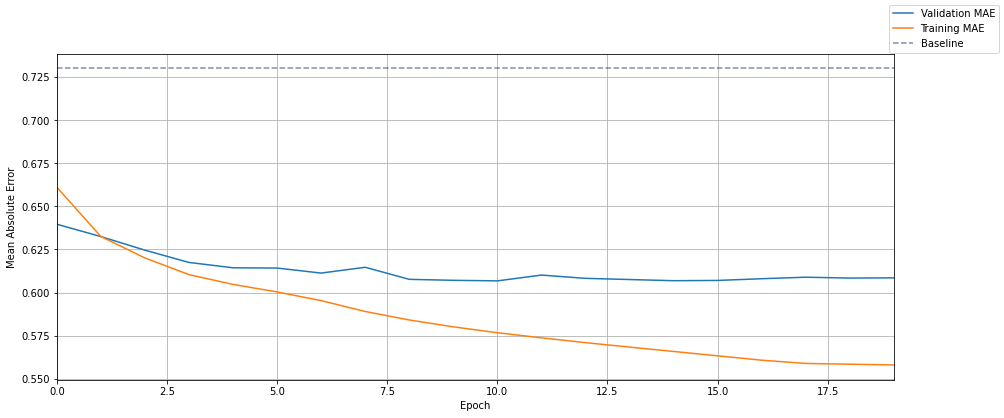

In [13]:
epoch_iota = np.arange(len(train_maes))

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(epoch_iota, test_maes, label='Validation MAE')
ax.plot(epoch_iota, train_maes, label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=epoch_iota[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

## Exploring Embeddings

In [15]:
from sklearn.manifold import TSNE
from matplotlib import offsetbox
import matplotlib.patheffects as PathEffects

In [370]:
# Manually choose a few different "kinds" of movies. 
# Each grouping should be more "similar" to other movies in that group than to the remaining movies.

titles = [
  'The Lord of the Rings: The Fellowship of the Ring',
  'The Lord of the Rings: The Two Towers',
  'The Lord of the Rings: The Return of the King',
  
  'Star Wars: Episode IV - A New Hope',
  'Star Wars: Episode VI - Return of the Jedi', 
  'Star Wars: Episode V - The Empire Strikes Back', 
  
  'The Little Mermaid',
  'Toy Story',
  'The Lion King',
  
  'Casablanca',
  'The Princess Bride',
  'Annie Hall',
]

In [371]:
interesting_movies = movies_df[movies_df['title'].isin(titles)]
interesting_movies

,movieId,title,year
0,0,Toy Story,1995
257,257,Star Wars: Episode IV - A New Hope,1977
360,360,The Lion King,1994
895,895,Casablanca,1942
1171,1171,Star Wars: Episode V - The Empire Strikes Back,1980
1172,1172,The Princess Bride,1987
1184,1184,Star Wars: Episode VI - Return of the Jedi,1983
1203,1203,Annie Hall,1977
1997,1997,The Little Mermaid,1989
4897,4897,The Lord of the Rings: The Fellowship of the Ring,2001


In [372]:
movie_embeddings = np.zeros((len(interesting_movies), config.emb_dim), dtype=np.float32)
for i, (movie_id, _) in enumerate(interesting_movies.iterrows()):
  for j in range(len(state.params['movie']['embedding'][movie_id])):
    movie_embeddings[i,j] = float(state.params['movie']['embedding'][movie_id,j])

In [395]:
X_embedded = TSNE(n_components=2,  perplexity=3, learning_rate=10, init='random', metric='cosine', random_state=42).fit_transform(movie_embeddings)

/home/josh/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [396]:
def plot(x, movies):
  
  f = plt.figure(figsize=(8,8))
  ax = plt.subplot(aspect='equal')
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40)
  plt.xlim(-25, 25)
  plt.ylim(-25, 25)
  ax.axis('off')
  ax.axis('tight')
  
  for i in range(len(movies)):
    xtext, ytext = x[i]
    movie_name = train_df[train_df['movieId'] == movies.iloc[i]['movieId']]['title'].iloc[0]
    txt = ax.text(xtext, ytext, movie_name, fontsize=10)

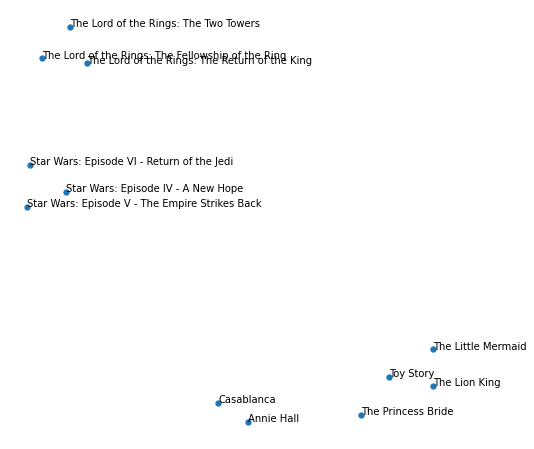

In [397]:
plot(X_embedded, interesting_movies)

Cool! There's some degree of clustering going on here. 

In reality it took a lot of brute force work to generate this visualization. However the embeddings really are more similar for movies within each category:

In [398]:
interesting_movies

,movieId,title,year
0,0,Toy Story,1995
257,257,Star Wars: Episode IV - A New Hope,1977
360,360,The Lion King,1994
895,895,Casablanca,1942
1171,1171,Star Wars: Episode V - The Empire Strikes Back,1980
1172,1172,The Princess Bride,1987
1184,1184,Star Wars: Episode VI - Return of the Jedi,1983
1203,1203,Annie Hall,1977
1997,1997,The Little Mermaid,1989
4897,4897,The Lord of the Rings: The Fellowship of the Ring,2001


In [399]:
movie_embeddings

array([[-0.8130226 ,  3.075013  , -3.3100736 ,  2.7651873 ,  1.2883552 ,
        -0.00996334, -1.0612997 ,  1.6736838 ],
       [-0.8961817 , -0.92627394, -4.602556  ,  1.6467972 , -0.8129486 ,
        -3.7206893 , -3.525724  ,  2.3293238 ],
       [ 0.5139875 ,  1.1796199 , -2.9330792 ,  1.3637384 ,  0.5506415 ,
         0.85323846, -0.38807836,  2.4007664 ],
       [-3.1166441 ,  2.2257984 , -3.1644495 , -0.8942525 ,  1.1227427 ,
        -2.5512593 , -0.04557527,  1.40088   ],
       [-0.70245045, -1.212747  , -4.635811  ,  1.8253354 , -0.8890731 ,
        -3.5188484 , -4.326776  ,  1.8938264 ],
       [-1.5266738 ,  1.6315366 , -2.8100011 ,  1.0970278 ,  1.3713809 ,
         1.9871503 , -4.0143943 ,  1.68049   ],
       [-0.09125451, -1.3291128 , -3.6289752 ,  1.179413  , -1.4521183 ,
        -2.8858395 , -3.2056038 ,  2.5509002 ],
       [-3.5409079 ,  1.1511556 , -1.8955173 , -1.8443542 ,  1.2076293 ,
         0.40972853, -1.1308768 , -0.7938176 ],
       [ 0.46610513,  2.695714  